# 2b. Supervised Model on Unseen Data

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import pickle

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score

## Exploratory Data Analysis and Preproccessing

In [37]:
# import tweets
tweets = pd.read_csv("../data/Current_Tweets/RT_tweets_official_07312019.csv")

In [38]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2019-07-31 19:57:12,NaN,[],1156655067535224832,Updated: Disabled vehicle in Duval on I-295 E ...,official,fl511_northeast
1,2019-07-31 19:53:12,NaN,[],1156654059790712835,Updated: Disabled vehicle in Duval on I-295 E ...,official,fl511_northeast
2,2019-07-31 19:49:14,NaN,[],1156653061533851649,Updated: Disabled vehicle in Duval on I-295 E ...,official,fl511_northeast
3,2019-07-31 19:34:13,NaN,[],1156649282281332739,Cleared: Planned construction in Duval on SR-1...,official,fl511_northeast
4,2019-07-31 19:34:12,NaN,[],1156649281400520705,Cleared: Planned construction in Duval on SR-1...,official,fl511_northeast


In [39]:
# all tweets taken realtime will be from accounts that primarily report on
# traffic in jacksonville, fl, so state will be marked as Florida
accounts = tweets['username'].unique()
tweets['state'] = 'Florida'

In [40]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

In [41]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [42]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Create Dataframe of Tweets that mention keywords related to road closures

In [43]:
# establish list of words to search for in dataframe
closed_keywords = ['road closed', 'remains closed', 'closed',
                   'no travel', 'delay', 'lane', 
                   'disabled', 'traffic', 'fire', 'flood']

to_drop = ["open", "opened", "lifted", "plane", "reopened", "clear", "cleared"]

In [44]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
def tweet_filter (df, col, keywords, dropwords=None):
    
    query = []
    
    # populate query list with masks that test if a word is in datafram
    for word in keywords:
        mask = df[col].str.contains(word, regex=False, case=False)
        query.append(mask)
        
    # run filter, specifying ANY text
    filter_df = df[np.any(query, axis=0)]
    
    # test words to drop functionality
    if dropwords is not None:
        
        # drop words in drop words list
        return filter_df[~filter_df[col].str.contains('|'.join(dropwords))]
    
    else:
        return filter_df

In [45]:
# backup original tweet to new dataframe
tweets['tweet'] = tweets['text']

# make tweet text lowercase
tweets['text'] = tweets['text'].str.lower()

# run function on full dataframe
closed = tweet_filter(tweets, 'text', closed_keywords, to_drop)

In [46]:
# Create target variable 
closed['road_closure'] = 1
closed['tweet'].head()

0    Updated  Disabled vehicle in Duval on I-295 E ...
1    Updated  Disabled vehicle in Duval on I-295 E ...
2    Updated  Disabled vehicle in Duval on I-295 E ...
5    New  Disabled vehicle in Duval on I-295 E sout...
7    Updated  Object on roadway in St Johns on I-95...
Name: tweet, dtype: object

In [47]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_northeast    119
ActionTraffic        6
JFRDJAX              2
Name: username, dtype: int64

In [48]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(127, 233)


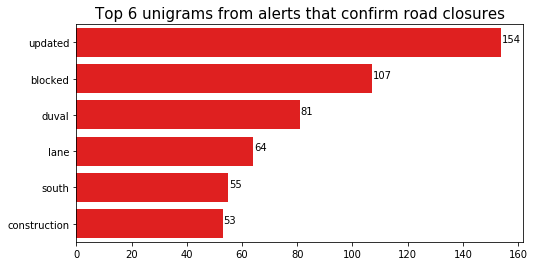

In [49]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [50]:
# Get index number of tweets identified as road closures 
closed_index = list(closed.index)

# Remove all road closure tweets from full dataframe
tweets_open = tweets.drop(closed_index)

# Drop any instances where false positives might occur
tweets_open = tweets_open[~tweets_open.text.str.contains("remains closed")]
tweets_open = tweets_open[~tweets_open.text.str.contains("remains close")]

# Shape
tweets_open.shape

(73, 9)

In [51]:
# To maintain balanced classes, drop rows in `tweets_open` so that they are equal to `closed`
tweets_open = tweets_open.iloc[0:(closed.shape[0])]

In [52]:
# Create target variable 
tweets_open['road_closure'] = 0
tweets_open.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
3,2019-07-31 19:34:13,NaN,[],1156649282281332739,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
4,2019-07-31 19:34:12,NaN,[],1156649281400520705,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
6,2019-07-31 19:00:11,NaN,[],1156640719492276227,cleared object on roadway in st johns on i-95...,official,fl511_northeast,Florida,Cleared Object on roadway in St Johns on I-95...,0
9,2019-07-31 18:12:24,NaN,[],1156628692757557248,cleared planned construction in clay on sr-21...,official,fl511_northeast,Florida,Cleared Planned construction in Clay on SR-21...,0
14,2019-07-31 16:26:10,NaN,[],1156601959820005378,cleared vehicle on fire in st johns on i-95 s...,official,fl511_northeast,Florida,Cleared Vehicle on fire in St Johns on I-95 s...,0


In [53]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(73, 320)


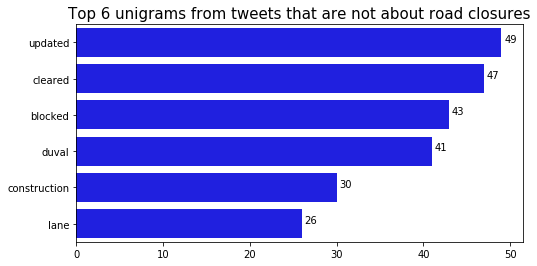

In [54]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [55]:
# Merge dataframes
tweets_training = pd.concat([tweets_open, closed], axis=0)
tweets_training.shape

(200, 10)

In [56]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
3,2019-07-31 19:34:13,NaN,[],1156649282281332739,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
4,2019-07-31 19:34:12,NaN,[],1156649281400520705,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
6,2019-07-31 19:00:11,NaN,[],1156640719492276227,cleared object on roadway in st johns on i-95...,official,fl511_northeast,Florida,Cleared Object on roadway in St Johns on I-95...,0
9,2019-07-31 18:12:24,NaN,[],1156628692757557248,cleared planned construction in clay on sr-21...,official,fl511_northeast,Florida,Cleared Planned construction in Clay on SR-21...,0
14,2019-07-31 16:26:10,NaN,[],1156601959820005378,cleared vehicle on fire in st johns on i-95 s...,official,fl511_northeast,Florida,Cleared Vehicle on fire in St Johns on I-95 s...,0


# Modeling

In [57]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.635
0    0.365
Name: road_closure, dtype: float64

In [58]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [74]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .3,
                                                    random_state=42,
                                                    stratify=y)

In [60]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [61]:
# function to plot regression coeficients for NLP models
# modified code from jasmine vasandani
def regression_coef_plot(pipe, e_name, v_name):
    # Create list of logistic regression coefficients 
    lr_coef = np.array(pipe.best_estimator_.named_steps[e_name].coef_).tolist()
    lr_coef = lr_coef[0]

    # create dataframe from lasso coef
    lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
    pipe.best_estimator_.named_steps[v_name].get_feature_names(), columns = ["lr_coef"])

    # sort the values from high to low
    lr_coef = lr_coef.sort_values(by = 'lr_coef', 
    ascending = False)

    # Create top and bottom 10 
    df_head = lr_coef.head(10)
    df_tail = lr_coef.tail(10)

    # merge back together
    df_merged = pd.concat([df_head, df_tail], axis=0)

    # plot the sorted dataframe
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    fig.suptitle('Coefficients', size=14)
    ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
    data=df_merged, palette= 'cubehelix')
    ax.set(xlabel='Regression Coefficients')
    plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [62]:
# helper functions for ROC AUC curve
# modified code from Arielle Miro

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

In [63]:
# function to plot ROC AUC curve
# modified code from Tim Book
def roc_auc(X, y, estimator):
    
    # Create figure.
    plt.figure(figsize = (12,10))
    
    # calculate predicted probabilities
    pred_proba = [i[1] for i in estimator.predict_proba(X)]

    pred_df = pd.DataFrame({'true_values': y,
                            'pred_probs':pred_proba})

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {roc_auc_score(y, estimator.predict(X))}', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

## Logistic Regression with Count Vectorizor

In [75]:
# run pickled logisitic regression model

# load the model from disk
filename = '../data/Models/lr_cvec_07302019.sav'
lr = joblib.load(filename)

# Create the predictions for Y training data
y_pred = lr.predict(X_test)

print(f'Train Score: {lr.score(X_train, y_train)}')
print(f'Test Score: {lr.score(X_test, y_test)}')

Train Score: 0.9768671513549241
Test Score: 0.9940191387559808


Confusion matrix, without normalization
[[18  0]
 [ 0 32]]


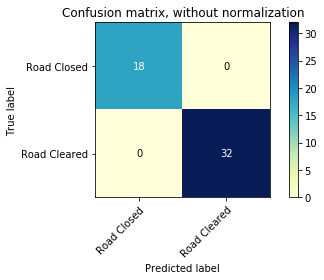

In [65]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# generate predictions
y_pred = lr.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

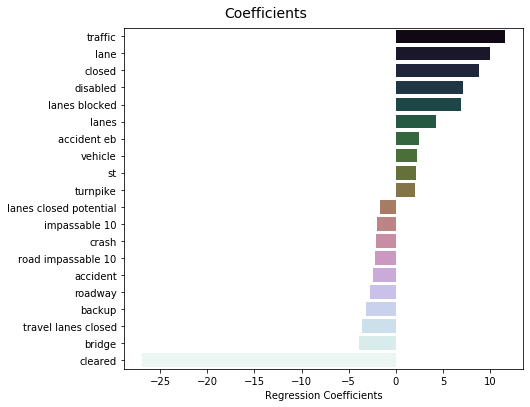

In [66]:
# run regression coeficient plot
regression_coef_plot(lr, 'lr', 'vec')

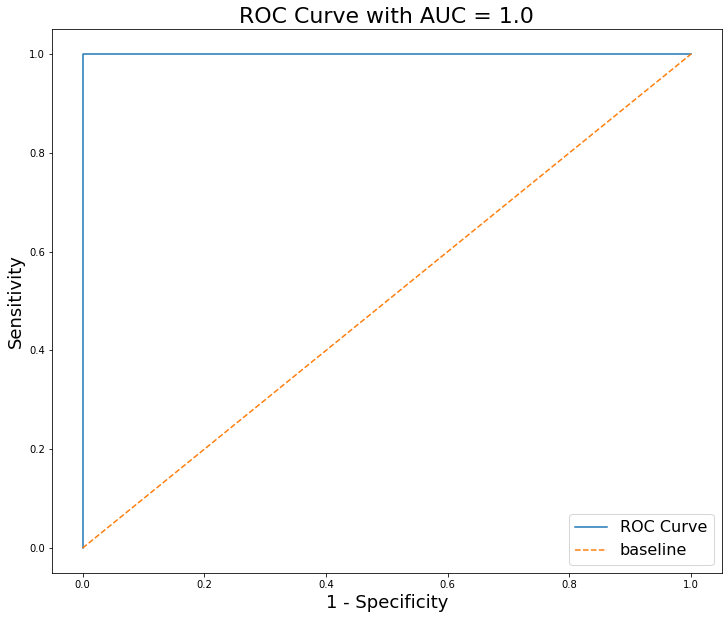

In [67]:
# run AUC ROC curve function
roc_auc(X_test, y_test, lr)

## TF-IDF and Gradient Boosting

In [68]:
# run gradient pickled boosting classifier

# load the model from disk
filename = '../data/Models/gb_tvec_07302019.sav'
gb = joblib.load(filename)

# Create the predictions for Y training data
y_pred = gb.predict(X_test)

print(f'Train Score: {gb.score(X_train, y_train)}')
print(f'Test Score: {gb.score(X_test, y_test)}')

Train Score: 0.9756937799043062
Test Score: 1.0


Confusion matrix, without normalization
[[18  0]
 [ 0 32]]


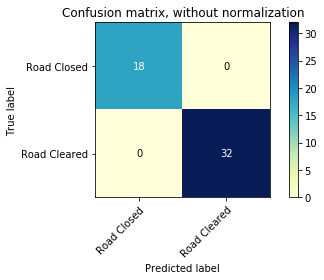

In [69]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Road Cleared'])

# generate predictions
y_pred = gb.predict(X_test)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

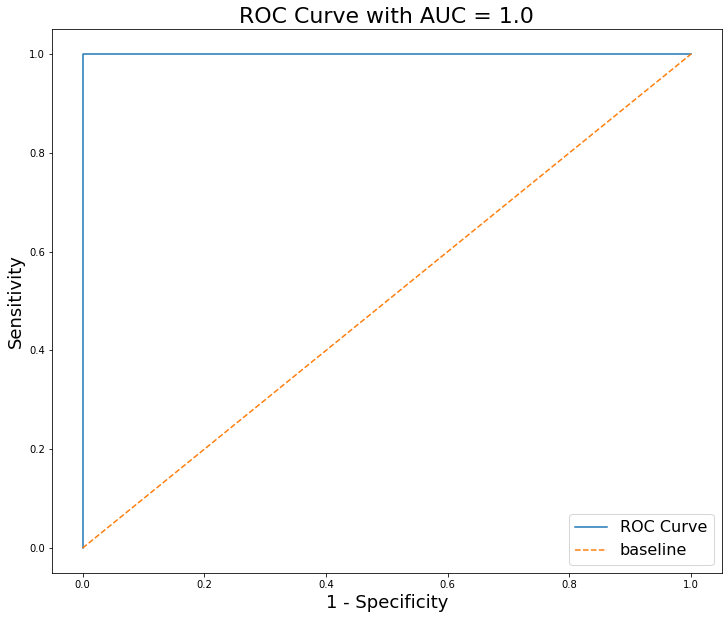

In [70]:
# run AUC ROC curve function
roc_auc(X_test, y_test, gb)

## Export Training Dataframe

In [71]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,state,tweet,road_closure
3,2019-07-31 19:34:13,NaN,[],1156649282281332739,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
4,2019-07-31 19:34:12,NaN,[],1156649281400520705,cleared planned construction in duval on sr-1...,official,fl511_northeast,Florida,Cleared Planned construction in Duval on SR-1...,0
6,2019-07-31 19:00:11,NaN,[],1156640719492276227,cleared object on roadway in st johns on i-95...,official,fl511_northeast,Florida,Cleared Object on roadway in St Johns on I-95...,0
9,2019-07-31 18:12:24,NaN,[],1156628692757557248,cleared planned construction in clay on sr-21...,official,fl511_northeast,Florida,Cleared Planned construction in Clay on SR-21...,0
14,2019-07-31 16:26:10,NaN,[],1156601959820005378,cleared vehicle on fire in st johns on i-95 s...,official,fl511_northeast,Florida,Cleared Vehicle on fire in St Johns on I-95 s...,0


In [72]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_RT_official_07312019.csv', index = False)